In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
colab=1

In [ ]:
!pip install tensorflow~=2.2.0 tensorflow_gcs_config~=2.2.0
import tensorflow as tf
import requests
import os
resp = requests.post("http://{}:8475/requestversion/{}".format(os.environ["COLAB_TPU_ADDR"].split(":")[0], tf.__version__))
if resp.status_code != 200:
  print("Failed to switch the TPU to TF {}".format(version))

In [ ]:
!pip install -q efficientnet >> /dev/null

import pandas as pd, numpy as np
import tensorflow as tf, re, math, gc, os
import random
import tensorflow.keras.backend as K
import tensorflow_hub as hub
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
print(tf.__version__)

if not colab:
    from kaggle_datasets import KaggleDatasets

2.2.0


In [ ]:
DEVICE = "TPU"
SEED = 201
FOLDS = 15
IMG_SIZES = [384] * FOLDS

INC2019 = [1] * FOLDS
INC2018 = [1] * FOLDS
MALIGNANT_EXTRA = [1] * FOLDS
MALIGNANT_1 = [0] *FOLDS
PSEUDO_LABELS = [0]*FOLDS

BATCH_SIZES = [32] * FOLDS
EPOCHS = [20] * FOLDS
EFF_NETS = [5] * FOLDS
WGTS = [1/FOLDS] * FOLDS
TTA = 20
VERBOSE = 1
DISPLAY_PLOT = False
FOLDER = 'Experiment_x41'

if colab:
    PATH = '/content/drive/My Drive/Kaggle/siim_melanoma_csvs/With_TTA_and_oof'
else:
    PATH=''
PATH = os.path.join(PATH, FOLDER)
os.makedirs(PATH, exist_ok=True)
PATH

'/content/drive/My Drive/Kaggle/siim_melanoma_csvs/With_TTA_and_oof/Experiment_x41'

In [ ]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.38.118.138:8470
initializing  TPU ...


INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


In [ ]:
print(IMG_SIZES)
GCS_PATH = [None]*FOLDS; GCS_PATH2 = [None]*FOLDS
if not colab:
    for i,k in enumerate(IMG_SIZES):
        GCS_PATH[i] = KaggleDatasets().get_gcs_path('melanoma-%ix%i'%(k,k))
        GCS_PATH2[i] = KaggleDatasets().get_gcs_path('isic2019-%ix%i'%(k,k))
else:
    # 512
    #GCS_PATH = ['gs://kds-e2edf129ef071e4a88dc9eff1bc7ad658b1463dd97630b49ad2852bd'] * FOLDS
    #GCS_PATH2 = ['gs://kds-9e6fecc9d41a3eae8ca289c0c98d58265f57d48d9d3e9e278f1c105b'] * FOLDS 
    #MALIGNANT_PATH = ['gs://kds-2bda56adf5787f0d0bd28a315f4efef5b4459feeaf630ba859fe7742'] * FOLDS 

    # 384
    GCS_PATH = ['gs://kds-4794b97a7db9238be7b3a7e36e6d03f2de112b355765280d28e2b579'] * FOLDS
    GCS_PATH2 = ['gs://kds-ba3a4a10d62d1e054c5eb06cc1cc58dca6e03bb18f5f06af448dec55'] * FOLDS 
    MALIGNANT_PATH = ['gs://kds-4dacd59e0327aff4eef56d9398ecced45e56a0afa6a43bf6bed7251b'] * FOLDS 
    PSEUDO_GCS_PATH = ['gs://kds-8b54a75f674a62c1bc59d52860e190a93df600ce3d667dabcd273fd0'] * FOLDS

print(GCS_PATH[0])
print(GCS_PATH2[0])
print(MALIGNANT_PATH[0])
print(PSEUDO_GCS_PATH[0])

MALIGNANT_FILES = tf.io.gfile.glob(MALIGNANT_PATH[0] + '/train*.tfrec')
MALIGNANT_EXTRA_FILES = MALIGNANT_FILES[15:30] + MALIGNANT_FILES[30:60][1::2]
MALIGNANT_1_FILES = MALIGNANT_FILES[0:15]

PSEUDO_LABEL_FILES = tf.io.gfile.glob(PSEUDO_GCS_PATH[0] + '/train*.tfrec')

files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
files2_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH2[0] + '/train*.tfrec')))

files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/test*.tfrec')))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)
print(count_data_items(MALIGNANT_1_FILES))
print(count_data_items(MALIGNANT_EXTRA_FILES))
print(count_data_items(PSEUDO_LABEL_FILES))
print(count_data_items(files_train))
print(count_data_items(files2_train))
print(count_data_items(files_test))

[384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384]
gs://kds-4794b97a7db9238be7b3a7e36e6d03f2de112b355765280d28e2b579
gs://kds-ba3a4a10d62d1e054c5eb06cc1cc58dca6e03bb18f5f06af448dec55
gs://kds-4dacd59e0327aff4eef56d9398ecced45e56a0afa6a43bf6bed7251b
gs://kds-8b54a75f674a62c1bc59d52860e190a93df600ce3d667dabcd273fd0
581
1765
1823
32692
25272
10982


In [ ]:
ROT_ = 180.0
SHR_ = 0    #2
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.
    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    XDIM = DIM%2
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)        
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))  
    return tf.reshape(d,[DIM, DIM,3])

def random_blockout(img, img_size, sl=0.2, sh=0.5):
    p=random.random()
    if p>=0.25:
        h, w, c = img_size, img_size, 3
        origin_area = tf.cast(h*w, tf.float32)

        e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * sl)), tf.int32)
        e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh * sh)), tf.int32)

        e_height_h = tf.minimum(e_size_h, h)
        e_width_h = tf.minimum(e_size_h, w)

        erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
        erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

        erase_area = tf.zeros(shape=[erase_height, erase_width, c])
        erase_area = tf.cast(erase_area, tf.uint8)

        pad_h = h - erase_height
        pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
        pad_bottom = pad_h - pad_top

        pad_w = w - erase_width
        pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
        pad_right = pad_w - pad_left

        erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
        erase_mask = tf.squeeze(erase_mask, axis=0)
        erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

        return tf.cast(erased_img, img.dtype)
    else:
        return tf.cast(img, img.dtype)

def dropout(image, DIM=256, PROBABILITY = 0.25, CT = 32, SZ = 0.125):
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1) < PROBABILITY, tf.int32)
    if (P == 0)|(CT == 0)|(SZ == 0): return image
    for k in range( CT ):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*DIM,tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
    image = tf.reshape(image,[DIM,DIM,3])
    return image

In [ ]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        #'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

def prepare_image(img, train=True, augment=True, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0

    #img = tf.image.rgb_to_yuv(img)
    
    if augment:
        img = transform(img,DIM=dim)

        #img = tf.image.rgb_to_hsv(img)

        img = tf.image.random_flip_left_right(img)
        img = tf.image.rot90(img, k = np.random.randint(4))
        img = tf.image.random_flip_up_down(img)
        #img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)

        if train:
            #img = dropout(img, DIM=dim, PROBABILITY=0.80, CT=16, SZ = 0.1)
            #img = random_blockout(img=img, img_size=dim)
            pass
        
    img = tf.reshape(img, [dim,dim, 3])        
    return img

In [ ]:
def get_dataset(files, train = True, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    if not train:
        ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, train=train, augment=augment, dim=dim), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

In [ ]:
def binary_focal_loss(gamma=2., alpha=.25):
    def binary_focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        epsilon = K.epsilon()
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return binary_focal_loss_fixed

def get_lr_callback(batch_size):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
    
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max    
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [ ]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def build_model(dim=128, ef=0):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))

    base1 = EFNS[ef](input_shape=(dim,dim,3),weights='noisy-student',include_top=False, pooling='avg')
    #base1 = tf.keras.applications.Xception(include_top=False, input_shape=(dim,dim,3),weights='imagenet', pooling='avg')
    
    x = base1(inp)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp,outputs=x)

    #opt = tf.keras.optimizers.SGD(learning_rate=1e-6)
    #opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
    opt = tf.keras.optimizers.Nadam(learning_rate=3e-4)
    #opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-4, total_steps=2980,warmup_proportion=0.1)
    #opt = tfa.optimizers.Lookahead(opt)
    #loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    loss = [binary_focal_loss(gamma = 2.0, alpha = 0.80)]
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

In [ ]:
class CustomSaver(tf.keras.callbacks.Callback):
    def __init__(self, fold):
        self.fold = fold
        self.list_ = [0]*5
    def on_epoch_end(self, epoch, logs={}):
        if epoch >= 10:
            self.model.save_weights(os.path.join(PATH, 'fold-%i-epoch-%i.h5'%(self.fold,epoch)))

In [ ]:
#check 4 filenames, 
#set learning rate
#val_loss or val_auc

SKIP_ALL = 5            #0 
SKIP_AFTER = 15         #15
SKIP_TRAIN = 0
MULTIPLE_CHECKPOINTS = False
SKIP_OOF_PREDICTION = False
NO_VALIDATION = False
ADD_PSEUDO = False
RETRAIN =  False        #0
REDUCE_LR_ON_PLAT = 0   #0
EPOCHS = [20] * FOLDS   #25
TTA = 20                #64
LR_CALLBACK = 1         #1 
BREAK = 1 

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
oof_tta = []

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):

    if fold<SKIP_ALL:
        continue
    if fold>=SKIP_AFTER:
        continue

    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25)
    print('#### FOLD',fold+1)
    print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
          (IMG_SIZES[fold],EFF_NETS[fold],BATCH_SIZES[fold]*REPLICAS))
    if NO_VALIDATION:
        files_train = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in range(15)])
    else:
        files_train = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    print(f'#### Using {count_data_items(files_train)} 2020 images')
    if INC2019[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1])
        print('#### Using 2019 external data')
    if INC2018[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2])
        print('#### Using 2018+2017 external data')
    for ii in range(MALIGNANT_EXTRA[fold]):
        files_train += MALIGNANT_EXTRA_FILES
        print(f'#### Using {count_data_items(MALIGNANT_EXTRA_FILES)} extra Malignant Images {ii+1} times')
    for jj in range(MALIGNANT_1[fold]):
        MALIGNANT_1_FILES_TRAIN = [MALIGNANT_1_FILES[x] for x in idxT]
        files_train += MALIGNANT_1_FILES_TRAIN
        print(f'#### Using {count_data_items(MALIGNANT_1_FILES_TRAIN)} Malignant 2020 Images {jj+1} times')
    if ADD_PSEUDO:
        files_train += PSEUDO_LABEL_FILES
        print(f'#### Using {count_data_items(PSEUDO_LABEL_FILES)} Pseudo Labeled Images 1 times')
       
    np.random.shuffle(files_train)
    print(f'####Total train images = {count_data_items(files_train)}')

    files_valid = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    print(f'####Total validation images = {count_data_items(files_valid)}')
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[fold] + '/test*.tfrec')))

    print('#'*25)
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
        
    if RETRAIN:
            print('Loading previous best model...')
            model.load_weights(os.path.join(PATH, 'fold-%i.h5'%fold))
    
    if fold<SKIP_TRAIN:
        print('#### SKIPPING FOLD',fold+1)

    else:
        print('Training...')
        if MULTIPLE_CHECKPOINTS:
            sv = CustomSaver(fold)
        else:
            sv = tf.keras.callbacks.ModelCheckpoint(os.path.join(PATH, 'fold-%i.h5'%fold), 
                                                    monitor='val_auc', 
                                                    save_best_only=True,
                                                    save_weights_only=True, 
                                                    mode='max')
        es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_auc', 
                                                 patience=20, mode='max',restore_best_weights=False)
        
        if not REDUCE_LR_ON_PLAT:
            lr_cb = get_lr_callback(BATCH_SIZES[fold])
        else:
            print('Using reduce_lr_on_plateau')
            lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.6,
                                                         patience=2, mode='max')

        if LR_CALLBACK:
            history = model.fit(get_dataset(files_train,train=True,augment=True,shuffle=True,repeat=True,
                                            dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]), 
                                epochs=EPOCHS[fold], 
                                callbacks = [sv, lr_cb, es_cb],
                                steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
                                validation_data=get_dataset(files_valid,train=False,augment=False,shuffle=False,
                                                            repeat=False, dim=IMG_SIZES[fold]),
                                verbose=VERBOSE
                                )
        else:
            print('No LR callback')
            history = model.fit(get_dataset(files_train,train=True,augment=True,shuffle=True,repeat=True,
                                            dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]), 
                                epochs=EPOCHS[fold], 
                                callbacks = [sv, es_cb],
                                steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
                                validation_data=get_dataset(files_valid,train=False,augment=False,shuffle=False,
                                                            repeat=False, dim=IMG_SIZES[fold]),
                                verbose=VERBOSE
                                )           
    if SKIP_OOF_PREDICTION:
        continue
    print('Loading best model...')
    model.load_weights(os.path.join(PATH, 'fold-%i.h5'%fold))
    
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid,train=False,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold])
    ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    oof_pred.append(np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
    #oof_pred.append(model.predict(get_dataset(files_valid,dim=IMG_SIZES[fold]),verbose=1))

    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                           labeled=True, return_image_names=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append(np.ones_like(oof_tar[-1],dtype='int8')*fold)
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                     labeled=False, return_image_names=True)
    oof_names.append(np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
    
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    oof_tta.append(auc)
    try:
        oof_val.append(np.max( history.history['val_auc'] ))
    except:
        oof_val.append(-1)
    print('#### FOLD %i OOF AUC without TTA = %.5f, with TTA = %.5f'%(fold+1,oof_val[-1],auc))
    if BREAK:
        break

oof = np.concatenate(oof_pred) 
true = np.concatenate(oof_tar)
names = np.concatenate(oof_names)
folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.5f'%auc)
df_oof = pd.DataFrame(dict(image_name = names, target=true, pred = oof, fold=folds))
df_oof.to_csv(os.path.join(PATH, f'oof.csv'),index=False)  
print(oof_tta)

INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 6
#### Image Size 384 with EfficientNet B5 and batch_size 256
#### Using 30494 2020 images
#### Using 2019 external data
#### Using 2018+2017 external data
#### Using 1765 extra Malignant Images 1 times
####Total train images = 55845
####Total validation images = 2198
#########################
Training...
Epoch 1/20
218/218 [==============================] - 222s 1s/step - auc: 0.7477 - loss: 1.3352 - val_auc: 0.7574 - val_loss: 0.2345 - lr: 5.0000e-06
Epoch 2/20
218/218 [==============================] - 197s 905ms/step - auc: 0.8882 - loss: 0.8858 - val_auc: 0.8503 - val_loss: 0.1723 - lr: 6.8000e-05
Epoch 3/20
218/218 [==============================] - 198s 907ms/step - auc: 0.9170 - loss: 0.7731 - val_auc: 0.8752 - val_loss: 0.1708 - lr: 1.3100e-04
Epoch 4/20
218/218 [==============================] - 199s 912ms/step - auc: 0.9346 - loss: 0.6968 - val_auc: 0.8809 - val_loss: 0.1948 - lr: 1.9400e-04
Epoch 5/20
218/218 [============================

## TEST DATA

In [ ]:
%%time
#check 2 file names
TTA = 20

preds = np.zeros((count_data_items(files_test),FOLDS))
for fold in range(FOLDS):
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('#### FOLD',fold+1)
    print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
          (IMG_SIZES[fold],EFF_NETS[fold],BATCH_SIZES[fold]*REPLICAS))
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[fold] + '/test*.tfrec')))
    
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
        
    print('Loading best model...')
    model.load_weights(os.path.join(PATH, 'retrain_fold-%i.h5'%fold))
    
    print('Predicting Test with TTA...')
    ds_test = get_dataset(files_test,train=False,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold])
    ct_test = count_data_items(files_test) 
    STEPS = TTA * ct_test/BATCH_SIZES[fold]/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,]
    preds[:,fold] = np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1)

ds = get_dataset(files_test,train=False, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_names=True)
image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])
submission = pd.DataFrame(dict(image_name=image_names, target0=preds[:,0], target1=preds[:,1], 
                               target2=preds[:,2], target3=preds[:,3], target4=preds[:,4],
                               target5=preds[:,5], target6=preds[:,6], target7=preds[:,7],
                               target8=preds[:,8], target9=preds[:,9], target10=preds[:,10],
                               target11=preds[:,11], target12=preds[:,12], target13=preds[:,13],
                               target14=preds[:,14]))
submission = submission.sort_values('image_name') 
submission.to_csv(os.path.join(PATH, 'submission_foldwise.csv'), index=False)

INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 1
#### Image Size 384 with EfficientNet B5 and batch_size 256
Loading best model...
Predicting Test with TTA...
858/857 [==============================] - 180s 210ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 2
#### Image Size 384 with EfficientNet B5 and batch_size 256
Loading best model...
Predicting Test with TTA...
858/857 [==============================] - 179s 209ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 3
#### Image Size 384 with EfficientNet B5 and batch_size 256
Loading best model...
Predicting Test with TTA...
858/857 [==============================] - 183s 213ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 4
#### Image Size 384 with EfficientNet B5 and batch_size 256
Loading best model...
Predicting Test with TTA...
858/857 [==============================] - 183s 213ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 5
#### Image Size 384 with EfficientNet B5 and batch_size 256
Loading best model...
Predicting Test with TTA...
858/857 [==============================] - 182s 212ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 6
#### Image Size 384 with EfficientNet B5 and batch_size 256
Loading best model...
Predicting Test with TTA...
858/857 [==============================] - 183s 213ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.38.118.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 7
#### Image Size 384 with EfficientNet B5 and batch_size 256


In [ ]:
df_oof = pd.read_csv(os.path.join(PATH, 'oof_final.csv'))
df_oof.sort_values(by='pred', ascending=False).head(20)

,image_name,target,pred,fold
5844,ISIC_6932951,0,0.993202,2
12202,ISIC_5867911,1,0.982094,5
2931,ISIC_3697702,1,0.980361,1
16256,ISIC_4566200,0,0.978187,7
1422,ISIC_6841294,1,0.978181,0
19006,ISIC_7236143,0,0.976707,8
15486,ISIC_1016695,0,0.974736,7
1076,ISIC_5260050,1,0.973104,0
4855,ISIC_2535541,1,0.965168,2
15818,ISIC_2529871,0,0.956549,7


In [ ]:
roc_auc_score(df_oof['target'],df_oof['pred'])

0.9423421049542489

In [ ]:
submission_df = pd.read_csv(os.path.join(PATH, 'submission_foldwise.csv'))
submission_df.head()

,image_name,target0,target1,target2,target3,target4,target5,target6,target7,target8,target9,target10,target11,target12,target13,target14
0,ISIC_0052060,0.002760,0.005866,0.002587,0.004299,0.002004,0.005881,0.003851,0.008115,0.002983,0.009171,0.012939,0.014608,0.000856,0.002883,0.001169
1,ISIC_0052349,0.000583,0.003385,0.001244,0.001454,0.000739,0.000788,0.005049,0.002736,0.005135,0.006291,0.005857,0.003969,0.002280,0.004716,0.000594
2,ISIC_0058510,0.002536,0.003809,0.002115,0.004573,0.006081,0.002072,0.012542,0.004136,0.001837,0.002026,0.003383,0.011137,0.005716,0.021800,0.000619
3,ISIC_0073313,0.005101,0.003043,0.004098,0.005787,0.006521,0.001070,0.017038,0.003172,0.002116,0.002350,0.005058,0.003368,0.008654,0.003053,0.004752
4,ISIC_0073502,0.006165,0.004011,0.001172,0.013565,0.005787,0.010248,0.051425,0.012743,0.007094,0.023242,0.022490,0.003614,0.010583,0.005133,0.009109


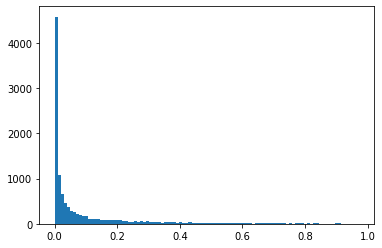

In [ ]:
plt.hist(submission_df.target0,bins=100)
plt.show()

In [ ]:
submission_df = pd.read_csv(os.path.join(PATH, 'submission_foldwise.csv'))
submission_df.head()
def MeanStacking(submission):
    print('Folds - ', FOLDS)
    submission['target'] = submission.iloc[:, 1:FOLDS+1].mean(axis=1)
    submission[['image_name', 'target']].to_csv(os.path.join(PATH, 'submission_mean.csv'), index=False)
    return submission

submission = MeanStacking(submission_df)

Folds -  15


In [ ]:
submission.sort_values(by='target', ascending=False).head()

,image_name,target0,target1,target2,target3,target4,target5,target6,target7,target8,target9,target10,target11,target12,target13,target14,target
7415,ISIC_6724629,0.971995,0.976052,0.980986,0.975235,0.961288,0.981735,0.904290,0.981544,0.940152,0.979962,0.959515,0.959038,0.971537,0.977486,0.916512,0.962489
592,ISIC_0634896,0.954004,0.947693,0.993089,0.983185,0.708598,0.961721,0.952265,0.980225,0.990385,0.973449,0.915451,0.971673,0.929803,0.929145,0.964636,0.943688
7199,ISIC_6518088,0.929571,0.985251,0.977078,0.921953,0.937872,0.963960,0.911113,0.946191,0.944934,0.873507,0.910072,0.944292,0.975338,0.955416,0.966348,0.942860
4613,ISIC_4258047,0.876762,0.948864,0.954489,0.955183,0.934035,0.959129,0.892395,0.944172,0.947131,0.959862,0.923624,0.930422,0.864986,0.938583,0.951609,0.932083
7200,ISIC_6519116,0.966338,0.972402,0.963700,0.937415,0.951794,0.958882,0.889422,0.915307,0.942706,0.929582,0.907949,0.887555,0.923501,0.935066,0.884289,0.931061


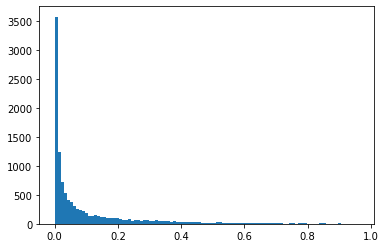

In [ ]:
plt.hist(submission.target,bins=100)
plt.show()